In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import crocoddyl 
import numpy as np
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
import numpy as np
import numdifftools as nd
import matplotlib.pyplot as plt
from jacobian import JacobianReg
import time

from tqdm import tqdm
%matplotlib inline


In [3]:
def _data(size:int = 1000, theta:float = 0.):
    """
    Returns xtrain, ytrain.
    Returns data in the form of x --> L(x)
    
    """

    _xtrain = []
    _ytrain = []
    
    for _ in range(size):
        # Generate random starting configuration
        xyz = [np.random.uniform(-2.1, 2.1), 
               np.random.uniform(-2.1, 2.1),
               theta]
        
        # Calculate the squared error
        cost = [squaredError(xyz)]
        
        _xtrain.append(xyz)
        _ytrain.append(cost)
        
    xtrain = torch.tensor(_xtrain, dtype = torch.float32)
    ytrain = torch.tensor(_ytrain, dtype = torch.float32)
        
    return xtrain, ytrain

In [4]:
def a2m(a):
    return np.matrix(a).T


def m2a(m):
    return np.array(m).squeeze()

def squaredError(x):
    """
    Squared Error is calculated with respected to [0, 0, 0]

    @params:
        1:  x : Matrix or List
        
    @returns: Sum of squared error    
       
    """

    return m2a(x)**2 if m2a(x).size == 1 else sum(m2a(x)**2)


    
def _jacobian(net, x, noutputs):
    """
    @params:
        1: net      = Neural net to be differentiated
        2: x        = Input tensor to the neural net.
        3: noutputs = Size of the output of the neural net. 
                      Needed to define the size of the jacobian tensor
        
    @returns: d(N(x)) / d(x)
    
    """
    
    x = x.squeeze()
    n = x.size()[0]
    x = x.repeat(noutputs, 1)
    x.requires_grad_(True)
    y = net(x)
    y.backward(torch.eye(noutputs))
    return x.grad.data


In [5]:
class SQNet(nn.Module):
    def __init__(self, 
                 input_features,
                 output_features,
                n_hidden_units = 16):
        
        super(SQNet, self).__init__()
        
        # Structure
        self.fc1 = nn.Linear(input_features, n_hidden_units)
        self.fc2 = nn.Linear(n_hidden_units, 3)
        self.fc3 = nn.Linear(3, 3)
        self.fc4 = nn.Linear(3, output_features)
        
        # Initialization protocol
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.xavier_uniform_(self.fc4.weight)

      
        self.device = torch.device('cpu')
        self.to(self.device)

    def forward(self, x):
        
        x1 = torch.tanh(self.fc1(x)) 
        x2 = torch.tanh(self.fc2(x1)) 
        x3 = self.fc3(x2) 
        x4 = self.fc4(x3) ** 2
        
        return x4
    

In [6]:
# Calculate MSE for test
def validation(net):
    """
    Returns the validation score(MSE) for regression
    
    """
    
    # Generate the test data... 1000 points
    xtest, ytest = _data(1000)
    
    # Set the network to eval mode
    net.eval()
    mean_squared_error = []
    
    with torch.no_grad():
        for x, y in zip(xtest, ytest):            
            prediction = net(x)
            squared_error = [(prediction.numpy() - y.numpy()) ** 2]
            mean_squared_error.append(squared_error)
            
    del xtest, ytest        
    print(f"Mean Squared Error during testing is {np.mean(mean_squared_error)}") 
    
def validate_msde(net):
    """
    Calculates Mean of ||Jacobian(Loss_func) - Jacobian(NeuralNet) || ** 2


    """

    jacobianLossFunction = nd.Jacobian(squaredError)

    msde = []

    for _ in range(1000):
        # Create random x as input
        x = [np.random.uniform(-2.1, 2.1), 
             np.random.uniform(-2.1, 2.1),
             0.]

        # jacobian of loss
        j_loss = jacobianLossFunction(x).squeeze()

        # jacobian of neuralNet
        x = torch.tensor(x, dtype = torch.float32)
        j_net = _jacobian(net, x, 1).numpy().squeeze()

        # Squared difference of jacobians
        msde.append([sum((j_loss - j_net) **2)])

    print(f"Mean Squared Differential Error during testing is {np.mean(msde)}") 

In [7]:
def _train(epochs=50, batchsize:int = 16, validate:bool = True):
    """
    Returns a trained neural network
    
    
    
    """
    
    
    # Make data and create a data generator to be used in training
    xtrain, ytrain = _data(1000)

    dataset = torch.utils.data.TensorDataset(xtrain,ytrain)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size = batchsize) # DataGenerator

    
    # Generate a Neural Net
    net = SQNet(xtrain.shape[1], ytrain.shape[1])
    net = net.float()
    net.train()
    
    optimizer = optim.Adam(net.parameters(), lr=1e-3)
    criteria = torch.nn.MSELoss(reduction='sum')

    
    # Jacobian regularization
    reg = JacobianReg() 
    lambda_JR = 0.01 
    t0 = time.time()    
    # Training    
    for epoch in tqdm(range(epochs)):        
        for data, target in dataloader:
            data.requires_grad=True
            optimizer.zero_grad()
            output = net(data)          
            loss_super = criteria(output, target)
            R = reg(data, output)                            # Jacobian regularization
            loss = loss_super + lambda_JR*R                  # full loss
            loss.backward()
            optimizer.step()                                      
                     
            
    print('Training lasted = %.0f seconds' % (time.time()-t0))    
    
    del xtrain, ytrain
    
    if validate:
        validation(net)
        validate_msde(net)
    return net

In [8]:

net = _train(epochs = 10000,
             batchsize = 1000,
            validate=True)



100%|██████████| 10000/10000 [02:22<00:00, 70.06it/s]


Training lasted = 143 seconds
Mean Squared Error during testing is 0.001556808827444911
Mean Squared Differential Error during testing is 0.050464044518880584


In [9]:
def scatter_loss_function():
    """
    Returns a scatter plot of the loss function
    """
    
    min_x, max_x, dim_x = (-2, 2, 1000)
    min_y, max_y, dim_y = (-2, 2, 1000)
    x = np.linspace(min_x, max_x, dim_x)
    y = np.linspace(min_y, max_y, dim_y)
    X,Y = np.meshgrid(x,y)
    
    z = np.array([squaredError([x,y]) for (x,y) in zip(np.ravel(X), np.ravel(Y))])
    Z = z.reshape(X.shape)
    
    plt.pcolormesh(X,Y,Z)    
    plt.xticks(np.arange(-2., 2.1, step=1))
    plt.yticks(np.arange(-2., 2.1, step=1))
    plt.title("Loss Function")
    cbar = plt.colorbar()
    cbar.set_label('Cost')
    #plt.savefig("Loss.png")
    plt.show()
    
    

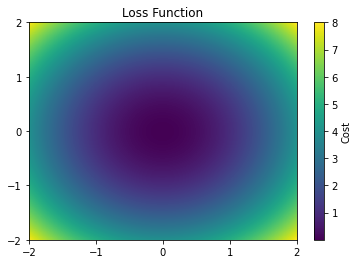

In [10]:
scatter_loss_function()

In [17]:
def scatter_network(net):
    """
    Generates three Scatter plots 
    1: N_w(x) w.r.t x1, x2

         
    """
    
    def predictions(X, Y):
        net.eval()
        _sample = [X, Y, 0.]
        sample = torch.tensor(_sample, dtype = torch.float32)
        with torch.no_grad():
            prediction = net(sample)
        nw = prediction.item()
        
        
        return nw
        
    

    x = np.linspace(-2, 2, 100)
    y = np.linspace(-2, 2, 100)
    X,Y = np.meshgrid(x,y)
    z = np.array([predictions(x,y) for (x,y) in zip(np.ravel(X), np.ravel(Y))])
    
    Z = z.reshape(X.shape)


    plt.pcolormesh(X,Y,Z)
    plt.xticks(np.arange(-2., 2.1, step=1))
    plt.yticks(np.arange(-2., 2.1, step=1))
    plt.title("Squared Network")
    cbar = plt.colorbar()
    cbar.set_label('Cost')
    plt.savefig("SQnet.png")
    plt.show()


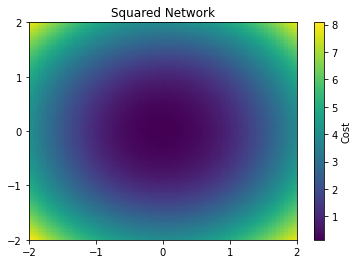

In [18]:
scatter_network(net)

In [19]:
def scatter_mse(net):

    
    def z_function(x, y):
        """
        Generate L(x) - N(w)
        """
        net.eval()
        theta = 0
        _sample = [x, y, theta]
        sample = torch.tensor(_sample, dtype = torch.float32)
        
        # Get L(w)
        lx = squaredError([x, y])
        
        # Get N(w)
        with torch.no_grad():
            prediction = net(sample)
        nw = prediction.item()
        
        return (lx - nw) **2
    
    
    
        
    min_x, max_x, dim_x = (-1, 1, 100)
    min_y, max_y, dim_y = (-1, 1, 100)
    x = np.linspace(min_x, max_x, dim_x)
    y = np.linspace(min_y, max_y, dim_y)
    X,Y = np.meshgrid(x,y)
    z = np.array([z_function(x,y) for (x,y) in zip(np.ravel(X), np.ravel(Y))])
    Z = z.reshape(X.shape)

    plt.pcolormesh(X,Y,Z)
    plt.xticks(np.arange(-1., 1))
    plt.yticks(np.arange(-1., 1))
    plt.title("|L(x) - N(w)|**2")
    cbar = plt.colorbar()
    cbar.set_label('error')
    plt.savefig("SQMSEerror.png")

    plt.show()
    

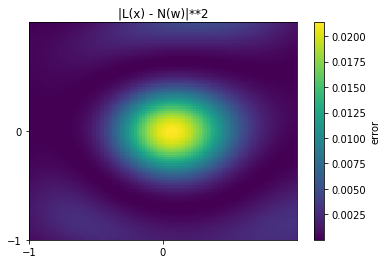

In [20]:
scatter_mse(net)

In [21]:
def scatter_msde(net):
    
    jacobianLossFunction = nd.Jacobian(squaredError)

    def z_function(x, y):
        """
        Generate L(x) - N(w)
        """
        # Input
        _sample = [x, y, 0.]
        sample = torch.tensor(_sample, dtype = torch.float32)
        
        # Get d L(x) / d(x)
        j_loss = jacobianLossFunction(_sample).squeeze()
        
        # Get d N_w(x) / d(x)
        j_net = _jacobian(net, sample, 1).numpy().squeeze()

        
        return sum((j_loss - j_net) **2)
    
    
    min_x, max_x, dim_x = (-1, 1, 100)
    min_y, max_y, dim_y = (-1, 1, 100)
    x = np.linspace(min_x, max_x, dim_x)
    y = np.linspace(min_y, max_y, dim_y)
    X,Y = np.meshgrid(x,y)
    z = np.array([z_function(x,y) for (x,y) in zip(np.ravel(X), np.ravel(Y))])
    Z = z.reshape(X.shape)

    plt.pcolormesh(X,Y,Z)
    plt.xticks(np.arange(-1., 1., step=1))
    plt.yticks(np.arange(-1., 1., step=1))
    plt.title("|dL(x) - d(N(x)|**2")
    cbar = plt.colorbar()
    cbar.set_label('error')
    plt.savefig("SQerror_msde3.png")
    plt.show()
    

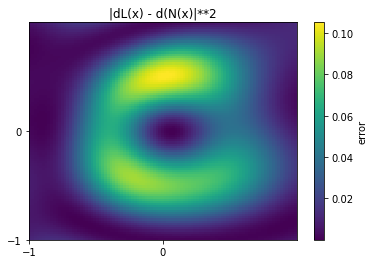

In [22]:
scatter_msde(net)

################################################

To-Do: hyper param optimization


For the feedforward Net:
        
    Training lasted      = 233 seconds
    MSE                  = 8.268032979685813e-05
    MSDE                 = 0.00821138243522207
    
For the Squared Network:
    
    Training lasted      = 143 seconds
    MSE                  = 0.001556808827444911
    MSDE                 = 0.050464044518880584
